In [1]:
# https://stackoverflow.com/questions/48302810/whats-the-difference-between-hidden-and-output-in-pytorch-lstm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
print(torch.cuda.is_available())
import os
np.random.seed(0)

False


In [2]:
# Define the folder path
folder_path = 'data'

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
relative_paths = [os.path.join(folder_path, file) for file in csv_files]

dfs = []

for csv in relative_paths:
    dfs.append(pd.read_csv(csv))
    

In [3]:
aep_hourly_csv = dfs[0]
time_series_data = aep_hourly_csv['AEP_MW']

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Create sequences
seq_length = 1000
X, y = create_sequences(time_series_data, seq_length)

# Split into training and test sets
train_size = int(0.9 * len(X)) 

# Note: we should start from X[train_size - seq_length:] instead
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)



In [4]:
def print_output_hook(module, _input, output):
    pass
#     print(f"Input shape: {_input[0].shape}")
#     print(f"Output shape: {output}")
#     print("-" * 50)

def first_iter_print_batch(epoch, i, inputs, targets):
    if i == 0 and epoch == 0:
        print(f"inputs shape: {inputs.shape}")
        print("inputs:")
        print(inputs)
        print("\n")
        print(f"targets shape: {targets.shape}")
        print("targets:")
        print(targets)

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=0.2, num_layers=3)
        self.fc = nn.Linear(hidden_size, 100)
        self.fc2 = nn.Linear(100, output_size)
        self.register_hooks()
    
    def register_hooks(self):
        for name, module in self.named_modules():
            if module != self:
                module.register_forward_hook(print_output_hook)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        out = self.fc2(out)
        return out

# Initialize the model
input_size = 1
hidden_size = 50
output_size = 1
model = RNN(input_size, hidden_size, output_size)


In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def save_checkpoint(model, optimizer, epoch, loss, checkpoint_path):
    """
    Saves a checkpoint with the model state, optimizer state, epoch, and loss.
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")

def load_checkpoint(checkpoint_path, model, optimizer):
    """
    Loads a checkpoint and returns the model, optimizer, epoch, and loss.
    """
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    return model, optimizer, start_epoch, checkpoint['loss']

    
def train_loop_per_epoch(train_loader, model, optimizer, epoch, checkpoint_path="checkpoint.pth"):
    epoch_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        # first_iter_print_batch(epoch, i, inputs, targets)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    
    if not os.path.exists(checkpoint_path) or epoch_loss < torch.load(checkpoint_path)['loss']:
        save_checkpoint(model, optimizer, epoch, epoch_loss, checkpoint_path)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')

def train_over_epochs(start_epoch, num_epochs, train_loader, model, optimizer, checkpoint_path="checkpoint.pth"):
    if os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, _ = load_checkpoint(checkpoint_path, model, optimizer)
    for epoch in range(start_epoch, num_epochs):
        train_loop_per_epoch(train_loader, model, optimizer, epoch)
    
num_epochs = 20
train_over_epochs(0, num_epochs, train_loader, model, optimizer)

Epoch 3, Loss: 6743271.817321904
Epoch 4, Loss: 6742700.565104936
Epoch 5, Loss: 6742248.085907479



KeyboardInterrupt



In [8]:
# Evaluate the model
model.eval()

targets_list = []
outputs_list = []


with torch.no_grad():
    total_loss = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        
        targets_list.extend(targets.numpy())
        outputs_list.extend(outputs.numpy())
    avg_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_loss:.4f}')

targets_array = np.array(targets_list)
outputs_array = np.array(outputs_list)

Test Loss: 6658119.1543


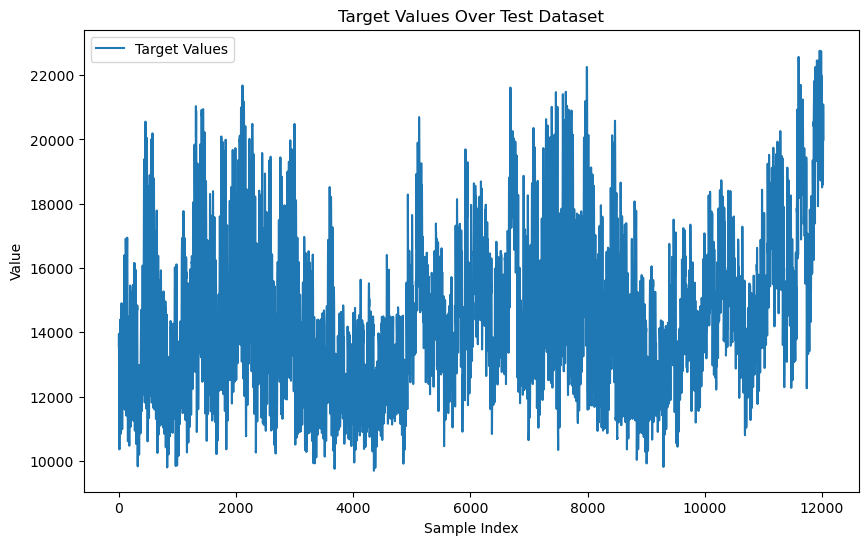

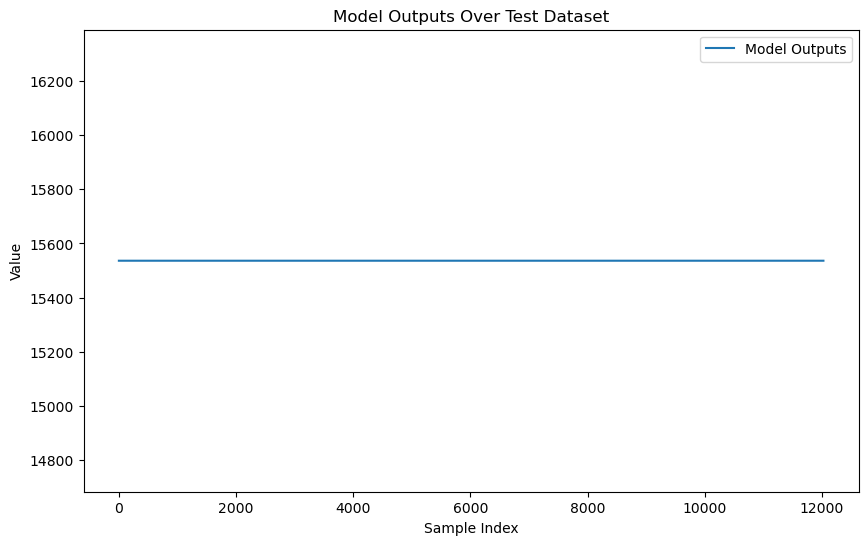

In [9]:
# Plot target values
plt.figure(figsize=(10, 6))
plt.plot(targets_array, label='Target Values')
plt.title('Target Values Over Test Dataset')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot model outputs
plt.figure(figsize=(10, 6))
plt.plot(outputs_array, label='Model Outputs')
plt.title('Model Outputs Over Test Dataset')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()
